# 10章 Uplift Modelingによるマーケティング資産の効率化

## 10.3 Uplift Modelingのためのデータセット生成

In [1]:
import random

def generate_sample_data(num, seed=1):
    # 返却するリストを確保
    is_cv_list = []
    is_treat_list = []
    feature_vector_list = []

    # 乱数を初期化
    random_instance = random.Random(seed)

    # 返す関数の特徴を設定
    feature_num = 8
    base_weight = [0.02, 0.03, 0.05, -0.04, 0.00, 0.00, 0.00, 0.00]
    lift_weight = [0.02, 0.00, 0.00, 0.05, -0.05, 0.00, 0.00, 0.00]

    for i in range(num):
        # 実験群かどうかを乱数で決定
        is_treat = random_instance.choice((True, False))
        # 特徴ベクトルを乱数で生成
        feature_vector = [random_instance.random() for n in range(feature_num)]
        # 内部的なコンバージョンレートを算出
        cv_rate = sum([feature_vector[n] * base_weight[n] for n in range(feature_num)])

        if is_treat:
            # 実験群であれば、lift_weightを加味する
            cv_rate += sum([feature_vector[n] * lift_weight[n] for n in range(feature_num)])
        
        # 実際にコンバージョンしたかどうかを決定する
        is_cv = cv_rate > random_instance.random()

        # 生成した値を格納
        is_cv_list.append(is_cv)
        is_treat_list.append(is_treat)
        feature_vector_list.append(feature_vector)
    
    # 値を返す
    return is_cv_list, is_treat_list, feature_vector_list

generate_sample_data(2)

([False, False],
 [True, False],
 [[0.5692038748222122,
   0.8022650611681835,
   0.06310682188770933,
   0.11791870367106105,
   0.7609624449125756,
   0.47224524357611664,
   0.37961522332372777,
   0.20995480637147712],
  [0.43276706790505337,
   0.762280082457942,
   0.0021060533511106927,
   0.4453871940548014,
   0.7215400323407826,
   0.22876222127045265,
   0.9452706955539223,
   0.9014274576114836]])

## 10.4 2つの予測モデルを利用したUplift Modeling

In [6]:
# trainデータの生成
sample_num = 100000
train_is_cv_list, train_is_treat_list, train_feature_vector_list = generate_sample_data(sample_num, seed=1)

# データをtreatmentとcontrolに分離
treat_is_cv_list = []
treat_feature_vector_list = []
control_is_cv_list = []
control_feature_vector_list = []

for i in range(sample_num):
    if train_is_treat_list[i]:
        treat_is_cv_list.append(train_is_cv_list[i])
        treat_feature_vector_list.append(train_feature_vector_list[i])
    else:
        control_is_cv_list.append(train_is_cv_list[i])
        control_feature_vector_list.append(train_feature_vector_list[i])

# コンバージョンレートを表示
print("treatment_cvr", treat_is_cv_list.count(True) / len(treat_is_cv_list))
print("control_cvr", control_is_cv_list.count(True) / len(control_is_cv_list))

treatment_cvr 0.04064347205141429
control_cvr 0.029544629532529343


Text(0, 0.5, 'conversion rate')

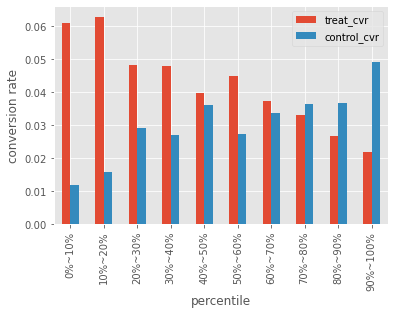

In [7]:
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter
plt.style.use('ggplot')

%matplotlib inline

# 学習器の生成
treat_model = LogisticRegression(C=0.01)
control_model = LogisticRegression(C=0.01)

# 学習器の構築
treat_model.fit(treat_feature_vector_list, treat_is_cv_list)
control_model.fit(control_feature_vector_list, control_is_cv_list)

# seedを変えて、テストデータを生成
test_is_cv_list, test_is_treat_list, test_feature_vector_list = generate_sample_data(sample_num, seed=42)

# それぞれの学習器でコンバージョンレートを予測
treat_score = treat_model.predict_proba(test_feature_vector_list)
control_score = control_model.predict_proba(test_feature_vector_list)

# スコアの算出、スコアは実験群の予測CVR / 統制群の予測CVR
# predict_probaはクラス所属確率のリストを返すため1番目を参照する
# numpy.ndarrayなので、そのまま割り算しても、要素の割り算になる
score_list = treat_score[:,1] / control_score[:,1]

# スコアが高い順に並べ替える
result = list(zip(test_is_cv_list, test_is_treat_list, score_list))
result.sort(key=itemgetter(2), reverse=True)

qdf = pd.DataFrame(columns=('treat_cvr', 'control_cvr'))

for n in range(10):
    # 結果を10%ごとに切断
    start = int(n * len(result) / 10)
    end = int((n + 1) * len(result) / 10) - 1
    quantiled_result = result[start:end]

    treat_uu = list(map(lambda item:item[1], quantiled_result)).count(True)
    control_uu = list(map(lambda item:item[1], quantiled_result)).count(False)

    treat_cv = [item[0] for item in quantiled_result if item[1] == True].count(True)
    control_cv = [item[0] for item in quantiled_result if item[1] == False].count(True)

    treat_cvr = treat_cv / treat_uu
    control_cvr = control_cv / control_uu

    label = "{}%~{}%".format(n*10, (n+1)*10)
    qdf.loc[label] = [treat_cvr, control_cvr]

qdf.plot.bar()
plt.xlabel("percentile")
plt.ylabel("conversion rate")

## 10.5 Uplift Modelingの評価方法、AUUC

Text(0, 0.5, 'conversion lift')

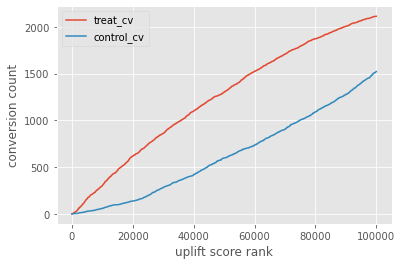

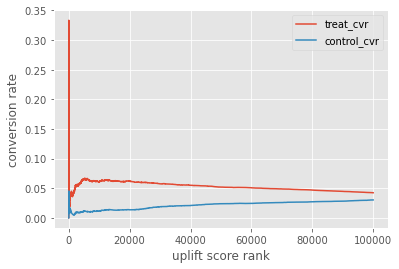

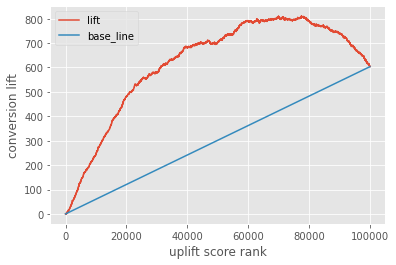

In [9]:
# スコア順に集計を行う
treat_uu = 0
control_uu = 0
treat_cv = 0
control_cv = 0
treat_cvr = 0
control_cvr = 0
lift = 0.0

stat_data = []

for is_cv, is_treat, score in result:
    if is_treat:
        treat_uu += 1
        if is_cv:
            treat_cv += 1
        treat_cvr = treat_cv / treat_uu
    else:
        control_uu += 1
        if is_cv:
            control_cv += 1
        control_cvr = control_cv / control_uu
    
    # コンバージョンレートの差に実験群の人数を掛けることでliftを算出
    # CVRの差なので、実験群と統制群の大きさが異なっていても算出可能
    lift = (treat_cvr - control_cvr) * treat_uu

    stat_data.append([is_cv, is_treat, score, treat_uu, control_uu, treat_cv, control_cv, treat_cvr, control_cvr, lift])

# 統計データを、DataFrameに変換する
df = pd.DataFrame(stat_data)
df.columns = ["is_cv", "is_treat", "score", "treat_uu", "control_uu", "treat_cv", "control_cv", "treat_cvr", "control_cvr", "lift"]

# ベースラインを書き加える
df["base_line"] = df.index * df["lift"][len(df.index) - 1] / len(df.index)

# 可視化を行う
df.plot(y=["treat_cv", "control_cv"])
plt.xlabel("uplift score rank")
plt.ylabel("conversion count")

df.plot(y=["treat_cvr", "control_cvr"])
plt.xlabel("uplift score rank")
plt.ylabel("conversion rate")

df.plot(y=["lift", "base_line"])
plt.xlabel("uplift score rank")
plt.ylabel("conversion lift")

AUUC: 312.9944528991244


Text(0, 0.5, 'conversion lift')

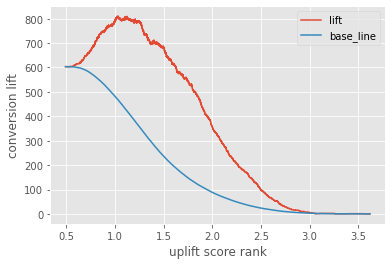

In [11]:
auuc = (df["lift"] - df["base_line"]).sum() / len(df["lift"])
print("AUUC:", auuc)

df.plot(x="score", y=["lift", "base_line"])
plt.xlabel("uplift score rank")
plt.ylabel("conversion lift")

## 10.6 実践的な問題での活用

In [12]:
import urllib.request
csv_url = "http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv"
csv_filename = "source_data.csv"
with open(csv_filename, "w") as fp:
    data = urllib.request.urlopen(csv_url).read()
    fp.write(data.decode("ascii"))

source_df = pd.read_csv(csv_filename)
source_df.head(10)


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0
5,6,2) $100 - $200,134.83,0,1,Surburban,0,Phone,Womens E-Mail,1,0,0.0
6,9,3) $200 - $350,280.20,1,0,Surburban,1,Phone,Womens E-Mail,0,0,0.0
7,9,1) $0 - $100,46.42,0,1,Urban,0,Phone,Womens E-Mail,0,0,0.0
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0
9,10,1) $0 - $100,32.84,0,1,Urban,1,Web,Womens E-Mail,0,0,0.0


In [13]:
mailed_df = source_df[source_df["segment"] != "No E-Mail"]
mailed_df = mailed_df.reset_index(drop=True)
mailed_df.head(10)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
2,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
3,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0
4,6,2) $100 - $200,134.83,0,1,Surburban,0,Phone,Womens E-Mail,1,0,0.0
5,9,3) $200 - $350,280.20,1,0,Surburban,1,Phone,Womens E-Mail,0,0,0.0
6,9,1) $0 - $100,46.42,0,1,Urban,0,Phone,Womens E-Mail,0,0,0.0
7,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0
8,10,1) $0 - $100,32.84,0,1,Urban,1,Web,Womens E-Mail,0,0,0.0
9,7,5) $500 - $750,548.91,0,1,Urban,1,Phone,Womens E-Mail,1,0,0.0


In [14]:
dummied_df = pd.get_dummies(mailed_df[["zip_code", "channel"]], drop_first=True)
feature_vector_df = mailed_df.drop(["history_segment", "zip_code", "channel", "segment", "visit", "conversion", "spend"], axis=1)
feature_vector_df = feature_vector_df.join(dummied_df)
feature_vector_df.head(10)

,recency,history,mens,womens,newbie,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
0,10,142.44,1,0,0,1,0,1,0
1,7,180.65,0,1,1,1,0,0,1
2,9,675.83,1,0,1,0,0,0,1
3,2,45.34,1,0,0,0,1,0,1
4,6,134.83,0,1,0,1,0,1,0
5,9,280.20,1,0,1,1,0,1,0
6,9,46.42,0,1,0,0,1,1,0
7,9,675.07,1,1,1,0,0,1,0
8,10,32.84,0,1,1,0,1,0,1
9,7,548.91,0,1,1,0,1,1,0


Text(0, 0.5, 'conversion lift')

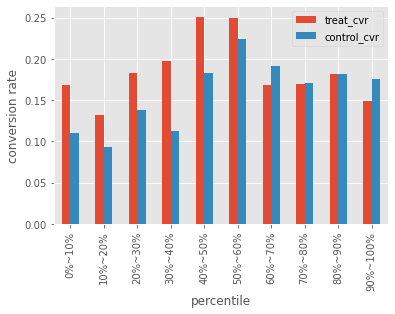

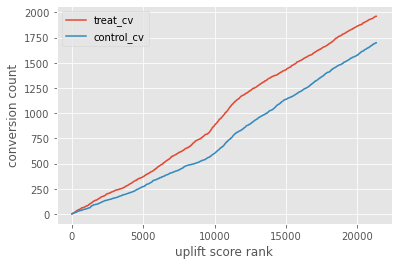

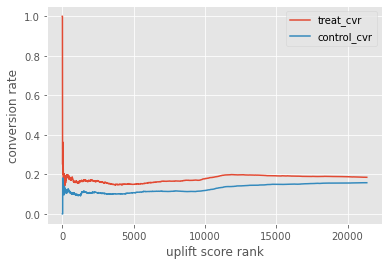

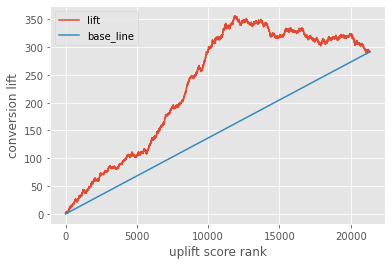

In [25]:
from sklearn.model_selection import train_test_split

is_treat_list = list(mailed_df["segment"] == "Mens E-Mail")
is_cv_list = list(mailed_df["visit"] == 1)

train_is_cv_list, test_is_cv_list, train_is_treat_list, test_is_treat_list, train_feature_vector_df, test_feature_vector_df = \
    train_test_split(is_cv_list, is_treat_list, feature_vector_df, test_size=0.5, random_state=42)

# indexをリセットする
train_feature_vector_df = train_feature_vector_df.reset_index(drop=True)
test_feature_vector_df = test_feature_vector_df.reset_index(drop=True)

train_sample_num = len(train_is_cv_list)

treat_is_cv_list = []
treat_feature_vector_list = []
control_is_cv_list = []
control_feature_vector_list = []

for i in range(train_sample_num):
    if train_is_treat_list[i]:
        treat_is_cv_list.append(train_is_cv_list[i])
        treat_feature_vector_list.append(train_feature_vector_df.loc[i])
    else:
        control_is_cv_list.append(train_is_cv_list[i])
        control_feature_vector_list.append(train_feature_vector_df.loc[i])

treat_model = LogisticRegression(C=0.01, max_iter=1000)
control_model = LogisticRegression(C=0.01, max_iter=1000)

treat_model.fit(treat_feature_vector_list, treat_is_cv_list)
control_model.fit(control_feature_vector_list, control_is_cv_list)

treat_score = treat_model.predict_proba(test_feature_vector_df)
control_score = control_model.predict_proba(test_feature_vector_df)
score_list = treat_score[:,1] / control_score[:,1]

result = list(zip(test_is_cv_list, test_is_treat_list, score_list))
result.sort(key=itemgetter(2), reverse=True)

treat_uu = 0
control_uu = 0
treat_cv = 0
control_cv = 0
treat_cvr = 0
control_cvr = 0
lift = 0.0

stat_data = []

for is_cv, is_treat, score in result:
    if is_treat:
        treat_uu += 1
        if is_cv:
            treat_cv += 1
        treat_cvr = treat_cv / treat_uu
    else:
        control_uu += 1
        if is_cv:
            control_cv += 1
        control_cvr = control_cv / control_uu
    
    lift = (treat_cvr - control_cvr) * treat_uu

    stat_data.append([is_cv, is_treat, score, treat_uu, control_uu, treat_cv, control_cv, treat_cvr, control_cvr, lift])

qdf = pd.DataFrame(columns=('treat_cvr', 'control_cvr'))

for n in range(10):
    start = int(n * len(result) / 10)
    end = int((n + 1) * len(result) / 10) - 1
    quantiled_result = result[start:end]

    treat_uu = list(map(lambda item:item[1], quantiled_result)).count(True)
    control_uu = list(map(lambda item:item[1], quantiled_result)).count(False)

    treat_cv = [item[0] for item in quantiled_result if item[1] == True].count(True)
    control_cv = [item[0] for item in quantiled_result if item[1] == False].count(True)

    treat_cvr = treat_cv / treat_uu
    control_cvr = control_cv / control_uu

    label = "{}%~{}%".format(n*10, (n+1)*10)
    qdf.loc[label] = [treat_cvr, control_cvr]

qdf.plot.bar()
plt.xlabel("percentile")
plt.ylabel("conversion rate")

df = pd.DataFrame(stat_data)
df.columns = ["is_cv", "is_treat", "score", "treat_uu", "control_uu", "treat_cv", "control_cv", "treat_cvr", "control_cvr", "lift"]

df["base_line"] = df.index * df["lift"][len(df.index) - 1] / len(df.index)

df.plot(y=["treat_cv", "control_cv"])
plt.xlabel("uplift score rank")
plt.ylabel("conversion count")

df.plot(y=["treat_cvr", "control_cvr"])
plt.xlabel("uplift score rank")
plt.ylabel("conversion rate")

df.plot(y=["lift", "base_line"])
plt.xlabel("uplift score rank")
plt.ylabel("conversion lift")